In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.7 MB/s eta 0:00:00


🔍 Collecting tweets...
✅ Collected 100 tweets
💭 Analyzing sentiment...
📊 Creating visualizations...


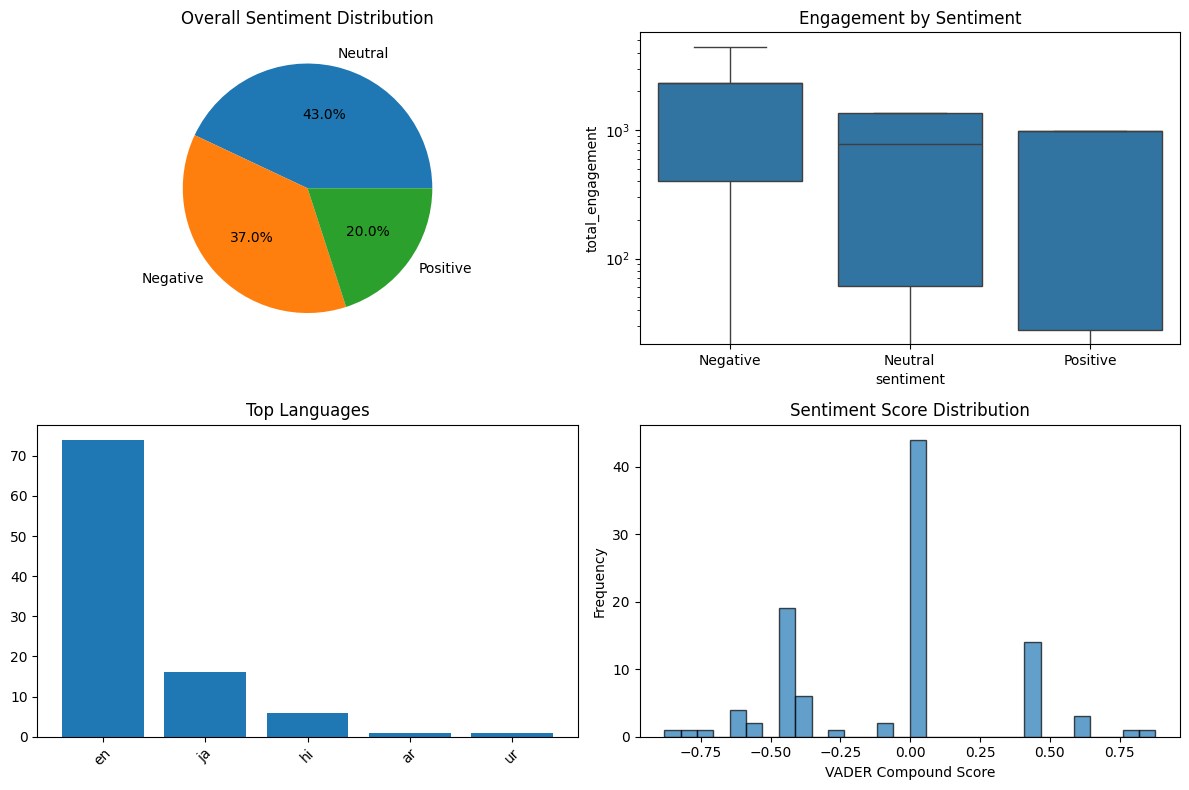

☁️ Generating word clouds...


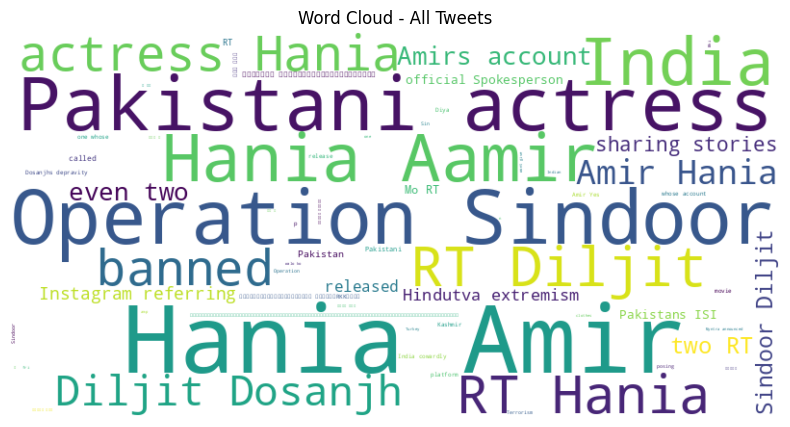

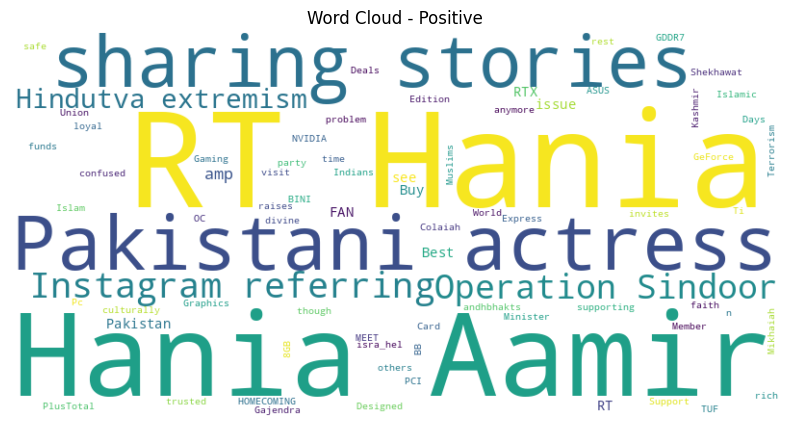

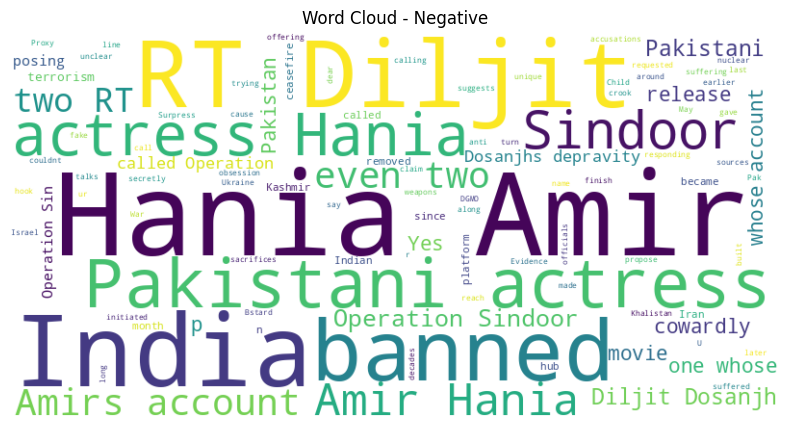

🔍 Generating insights...

📈 KEY INSIGHTS:
Total tweets analyzed: 100
Unique users: 86

💭 SENTIMENT DISTRIBUTION:
Neutral: 43.0%
Negative: 37.0%
Positive: 20.0%

🌐 LANGUAGE DISTRIBUTION:


KeyError: 'language_distribution'

In [ ]:
import tweepy
import pandas as pd
import numpy as np
import re
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

class TwitterSentimentAnalyzer:
    def __init__(self, bearer_token):
        """Initialize Twitter API and sentiment analyzers"""
        self.client = tweepy.Client(bearer_token=bearer_token)
        self.vader_analyzer = SentimentIntensityAnalyzer()

        # Keywords for Operation Sindoor
        self.keywords = [
            "Operation Sindoor", "#OperationSindoor", "Pahalgam attack",
            "India Pakistan", "surgical strikes", "LoC", "Kashmir",
            "ऑपरेशन सिंदूर", "پاکستان بھارت"  # Hindi/Urdu keywords
        ]

        self.stopwords = set(nltk.corpus.stopwords.words('english'))

    def collect_tweets(self, query, max_tweets=1000, days_back=7):
        """Collect tweets based on query with temporal filtering"""
        end_time = datetime.utcnow() - timedelta(seconds=15)
        start_time = end_time - timedelta(days=days_back)

        end_time_iso = end_time.isoformat("T") + "Z"
        start_time_iso = start_time.isoformat("T") + "Z"

        tweets_data = []

        try:
            tweets = tweepy.Paginator(
                self.client.search_recent_tweets,
                query=query,
                tweet_fields=['created_at', 'author_id', 'public_metrics', 'lang'],
                start_time=start_time_iso,
                end_time=end_time_iso,
                max_results=100
            ).flatten(limit=max_tweets)

            for tweet in tweets:
                tweet_data = {
                    'id': tweet.id,
                    'text': tweet.text,
                    'created_at': tweet.created_at,
                    'author_id': tweet.author_id,
                    'lang': tweet.lang,
                    'retweet_count': tweet.public_metrics['retweet_count'],
                    'like_count': tweet.public_metrics['like_count'],
                    'reply_count': tweet.public_metrics['reply_count'],
                    'quote_count': tweet.public_metrics['quote_count']
                }
                tweets_data.append(tweet_data)

        except Exception as e:
            print(f"Error collecting tweets: {e}")

        return pd.DataFrame(tweets_data)

    def preprocess_text(self, text):
        """Clean and preprocess tweet text"""
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove user mentions and hashtags for clean text analysis
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        # Remove special characters but keep basic punctuation
        text = re.sub(r'[^\w\s.,!?-]', '', text)

        return text

    def analyze_sentiment(self, df):
        """Perform sentiment analysis using multiple approaches"""
        sentiments = []

        for text in df['text']:
            clean_text = self.preprocess_text(text)

            # VADER Sentiment (good for social media)
            vader_scores = self.vader_analyzer.polarity_scores(clean_text)

            # TextBlob Sentiment
            blob = TextBlob(clean_text)

            # Determine overall sentiment
            if vader_scores['compound'] >= 0.05:
                sentiment = 'Positive'
            elif vader_scores['compound'] <= -0.05:
                sentiment = 'Negative'
            else:
                sentiment = 'Neutral'

            sentiments.append({
                'sentiment': sentiment,
                'vader_compound': vader_scores['compound'],
                'vader_positive': vader_scores['pos'],
                'vader_negative': vader_scores['neg'],
                'vader_neutral': vader_scores['neu'],
                'textblob_polarity': blob.sentiment.polarity,
                'textblob_subjectivity': blob.sentiment.subjectivity,
                'clean_text': clean_text
            })

        sentiment_df = pd.DataFrame(sentiments)
        return pd.concat([df, sentiment_df], axis=1)

    def create_visualizations(self, df):
        """Create basic visualizations"""
        plt.figure(figsize=(12, 8))

        # 1. Sentiment Distribution
        plt.subplot(2, 2, 1)
        sentiment_counts = df['sentiment'].value_counts()
        plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
        plt.title('Overall Sentiment Distribution')

        # 2. Engagement vs Sentiment
        plt.subplot(2, 2, 2)
        df['total_engagement'] = df['like_count'] + df['retweet_count'] + df['reply_count']
        sns.boxplot(data=df, x='sentiment', y='total_engagement')
        plt.title('Engagement by Sentiment')
        plt.yscale('log')

        # 3. Language Distribution
        plt.subplot(2, 2, 3)
        lang_counts = df['lang'].value_counts().head(5)
        plt.bar(lang_counts.index, lang_counts.values)
        plt.title('Top Languages')
        plt.xticks(rotation=45)

        # 4. Sentiment Score Distribution
        plt.subplot(2, 2, 4)
        plt.hist(df['vader_compound'], bins=30, alpha=0.7, edgecolor='black')
        plt.title('Sentiment Score Distribution')
        plt.xlabel('VADER Compound Score')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    def create_word_cloud(self, df, sentiment_filter=None):
        """Create word cloud for specific sentiment"""
        if sentiment_filter:
            text_data = df[df['sentiment'] == sentiment_filter]['clean_text']
        else:
            text_data = df['clean_text']

        # Combine all text
        all_text = ' '.join(text_data.dropna())

        # Remove common words
        words_to_remove = ['operation', 'sindoor', 'india', 'pakistan', 'tweet', 'twitter']
        for word in words_to_remove:
            all_text = all_text.replace(word, '')

        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            max_words=100,
            stopwords=self.stopwords
        ).generate(all_text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        title = f'Word Cloud - {sentiment_filter}' if sentiment_filter else 'Word Cloud - All Tweets'
        plt.title(title)
        plt.show()

    def generate_insights(self, df):
        """Generate key insights from the analysis"""
        insights = {}

        # Basic statistics
        insights['total_tweets'] = len(df)
        insights['unique_users'] = df['author_id'].nunique()
        insights['sentiment_distribution'] = df['sentiment'].value_counts(normalize=True).to_dict()

        # Engagement analysis
        insights['avg_engagement_by_sentiment'] = df.groupby('sentiment')[
            ['like_count', 'retweet_count', 'reply_count']
        ].mean().to_dict()

        # Language analysis
        #insights['language_distribution'] = df['lang'].value_counts().head(5).to_dict()

        # Most engaging tweets
        df['total_engagement'] = df['like_count'] + df['retweet_count'] + df['reply_count']
        top_tweets = df.nlargest(3, 'total_engagement')[['text', 'sentiment', 'total_engagement']]
        insights['most_engaging_tweets'] = top_tweets.to_dict('records')

        return insights

    def run_complete_analysis(self, query_terms=None, max_tweets=1000, days_back=7):
        """Run the complete sentiment analysis pipeline"""

        if query_terms is None:
            query_terms = ' OR '.join([f'"{term}"' for term in self.keywords])

        print("🔍 Collecting tweets...")
        df = self.collect_tweets(query_terms, max_tweets, days_back)

        if df.empty:
            print("❌ No tweets found for the given query.")
            return None, None

        print(f"✅ Collected {len(df)} tweets")

        print("💭 Analyzing sentiment...")
        df = self.analyze_sentiment(df)

        print("📊 Creating visualizations...")
        self.create_visualizations(df)

        print("☁️ Generating word clouds...")
        self.create_word_cloud(df)
        self.create_word_cloud(df, 'Positive')
        self.create_word_cloud(df, 'Negative')

        print("🔍 Generating insights...")
        insights = self.generate_insights(df)

        return df, insights

# Usage Example
def main():
    """Main function to run the analysis"""

    # Initialize analyzer (you need to provide your Twitter Bearer Token)
    BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAACTG2gEAAAAAAfSzHSlVpXM%2F8FIGJiXi8UhgVmY%3DVQCpkdgDzMFrK6hbDUs7gGxXsXNfW8AQ3fk12WCqFacvPeKAOB"
    analyzer = TwitterSentimentAnalyzer(BEARER_TOKEN)

    # Run analysis
    df, insights = analyzer.run_complete_analysis(
        max_tweets=100,  # Adjust based on your needs
        days_back=2
    )

    if df is not None:
        # Print key insights
        print("\n📈 KEY INSIGHTS:")
        print("="*50)
        print(f"Total tweets analyzed: {insights['total_tweets']}")
        print(f"Unique users: {insights['unique_users']}")

        print("\n💭 SENTIMENT DISTRIBUTION:")
        for sentiment, percentage in insights['sentiment_distribution'].items():
            print(f"{sentiment}: {percentage:.1%}")

      #  print("\n🌐 LANGUAGE DISTRIBUTION:")
      #  for lang, count in insights['language_distribution'].items():
            #print(f"{lang}: {count}")

        print("\n🔥 MOST ENGAGING TWEETS:")
        for i, tweet in enumerate(insights['most_engaging_tweets'], 1):
            print(f"\n{i}. Sentiment: {tweet['sentiment']}")
            print(f"   Engagement: {tweet['total_engagement']}")
            print(f"   Text: {tweet['text'][:100]}...")

        # Save results
        df.to_csv('operation_sindoor_sentiment_analysis.csv', index=False)
        pd.DataFrame([insights]).to_json('sentiment_insights.json', orient='records')

        print("\n💾 Results saved to CSV and JSON files")

if __name__ == "__main__":
    main()

# Configuration for different analysis scenarios
ANALYSIS_CONFIGS = {
    'real_time': {
        'max_tweets': 100,
        'days_back': 1,
        'update_frequency': 300  # 5 minutes
    },
    'comprehensive': {
        'max_tweets': 2000,
        'days_back': 14,
        'include_retweets': True
    },
    'quick_analysis': {
        'max_tweets': 200,
        'days_back': 3,
        'basic_metrics_only': True
    }
}